In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from copy import deepcopy
import warnings, graphviz, optuna

warnings.filterwarnings('ignore')
sns.set(style='white')
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

In [150]:
def load_data():
    trn = pd.read_csv('aug_train.csv')
    tst = pd.read_csv('aug_test.csv')
    tst_answer = np.load('jobchange_test_target_values.npy')
    tst['target'] = tst_answer
    trn.drop('enrollee_id', axis=1, inplace=True)
    tst.drop('enrollee_id', axis=1, inplace=True)
    trn['city'] = trn['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))
    tst['city'] = tst['city'].map(lambda x: 'city_'+str(int(x[5:])).zfill(3))

    # 모든 Null 값을 Missing으로 변경합니다.
    for col in tst.columns:
        trn[col].fillna('Missing', inplace=True)
        tst[col].fillna('Missing', inplace=True)

    # Missing 값의 갯수 Feature 생성
    trn['num_missing'] = (trn=='Missing').sum(axis=1)
    tst['num_missing'] = (tst=='Missing').sum(axis=1)
    return trn, tst

def labelencoder(train, test):
    # normianl feature는 labelencoder로 처리
    norminal = ['city', 'gender', 'relevent_experience', 'major_discipline', 'company_type']
    for col in norminal:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

    # ordinal feature는 자체적으로 생성한 dictionary로 처리합니다
    ordinal = {
        'enrolled_university':{'Full time course':3, 'Part time course':2, 'no_enrollment':1, 'Missing':0},
        'education_level':{'Phd':5, 'Masters':4, 'Graduate':3, 'High School':2, 'Primary School':1, 'Missing':0},
        'experience':{
            '>20':22, '20':21, '19':20, '18':19, '17':18, '16':17, '15':16, '14':15, '13':14, '12':13, '11':12, '10':11,
            '9':10, '8':9, '7':8, '6':7, '5':6, '4':5, '3':4, '2':3, '1':2 , '<1':1, 'Missing':0
        },
        'company_size':{'10000+':8, '5000-9999':7, '1000-4999':6, '500-999':5, '100-500':4, '50-99':3, '10/49':2, '<10':1, 'Missing':0},
        'last_new_job':{'>4':6, '4':5, '3':4, '2':3, '1':2, 'never':1, 'Missing':0}
    }
    for col in ordinal:
        train[col] = train[col].map(ordinal[col])
        test[col] = test[col].map(ordinal[col])
    return train, test

def oversampling(data, features):
    data_features, data_targets = SMOTE(random_state=RANDOM_STATE).fit_sample(data[features], data.target)
    data_targets = data_targets.to_frame()
    data_targets.columns = ['target']
    data = pd.concat([data_features, data_targets], axis=1)
    return data

def show_target_dist(df_list, title_list):
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    for n, df in enumerate(df_list):
        data = df['target'].value_counts()    
        ax = axes[n]
        ax.bar([0, 1], data.values, width=0.6, color=['lightgrey', '#2f5597'], ec='black', lw=0.5)
        for idx in data.index:
            ax.text(
                idx, data[idx]+200, format(data[idx],","), fontsize=11, fontweight='bold',
                ha='center', va='bottom'
            )
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0: Not looking for a job change', '1: looking for a job change'])
        ax.set_yticklabels(list(format(int(x), ",") for x in ax.get_yticks()))
        ax.set_ylim(0, 17000)
        ax.set_xlabel('Target')
        ax.set_ylabel('People')
        ax.set_title(title_list[n])
    plt.show()

def return_model_result(model_list, trn, trn_over, tst):    
    result = np.zeros((len(model_list), 6))    
    preds = []
    for n, model in enumerate(model_list):                
        model_ = deepcopy(model)
        model.fit(trn[features], trn['target'])                
        preds.append(model.predict_proba(tst[features]))
        
        model = deepcopy(model_)
        model.fit(trn_over[features], trn_over['target'])                        
        preds.append(model.predict_proba(tst[features]))
    return preds

def make_result_df(model_names, preds, tst):
    result_list = []
    for idx in range(0, len(preds), 2):
        result_list.append(accuracy_score(tst.target, np.argmax(preds[idx], axis=1)))
        result_list.append(accuracy_score(tst.target, np.argmax(preds[idx+1], axis=1)))
        result_list.append(log_loss(tst.target, preds[idx]))
        result_list.append(log_loss(tst.target, preds[idx+1]))
        result_list.append(roc_auc_score(tst.target, np.argmax(preds[idx], axis=1)))
        result_list.append(roc_auc_score(tst.target, np.argmax(preds[idx+1], axis=1)))
    result = np.array(result_list).reshape(len(model_list), -1)    
    result = pd.DataFrame(
        index=model_names, data=result,
        columns=[
            'acc_test', 'acc_test(over)', 'log_loss_test', 'log_loss_test(over)',
            'roc_score_test', 'roc_score_test(over)'
        ]
    )
    return result

def show_heatmap_roc(model_names, preds, tst):
    for idx in range(len(model_names)):        
        fig, axes = plt.subplots(figsize=(15, 4), ncols=3)        
        sns.heatmap(
            confusion_matrix(tst.target, np.argmax(preds[2*idx], axis=1)),
            ax=axes[0], annot=True, fmt=",", cbar=False,
            cmap='Blues', annot_kws={'fontweight':'bold'}
        )
        sns.heatmap(
            confusion_matrix(tst.target, np.argmax(preds[2*idx+1], axis=1)),
            ax=axes[1], annot=True, fmt=",", cbar=False,
            cmap='Blues', annot_kws={'fontweight':'bold'}
        )
        random_x = np.linspace(0, 1, 15)
        random_y = np.linspace(0, 1, 15)
        axes[2].plot(random_x, random_y, label='Random', color='black', ls=':', lw=1.5)
        
        n = 0
        colors=['#d1495b', '#00798c']
        for pred, label in zip([preds[2*idx], preds[2*idx+1]], ['train', 'train_over']):    
            fprs, tprs, _ = roc_curve(tst.target, pred[:, 1])     
            axes[2].plot(fprs, tprs, label=label, color=colors[n])
            axes[2].fill_between(fprs, tprs, color=colors[n], alpha=0.2)
            n += 1
        axes[2].fill_between(random_x, random_y, color='white')
            
        axes[0].set_title(model_names[idx] + ' Train')
        axes[1].set_title(model_names[idx] + ' Train(over)')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')        
        axes[1].set_xlabel('Predicted Label')
        axes[1].set_ylabel('True Label')        
        axes[2].legend()
        axes[2].set_title('ROC_CURVE')
        plt.show()

(19158, 14) (28762, 14) (2129, 14)


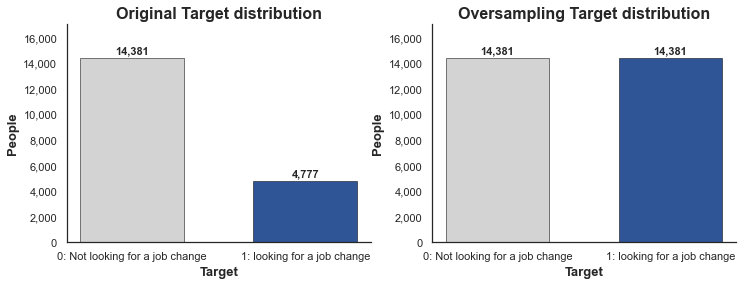

In [151]:
trn, tst = load_data()
trn, tst = labelencoder(trn, tst)
features = trn.drop('target', axis=1).columns
trn_over = oversampling(trn, features)
print(trn.shape, trn_over.shape, tst.shape)
show_target_dist([trn, trn_over], ['Original Target distribution', 'Oversampling Target distribution'])

In [152]:
# baseline 모델 리스트
model_list = [
    DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
    XGBClassifier(n_jobs=-1), LGBMClassifier(n_jobs=-1)
]
model_names = ['DecisionTree', 'RandomForest', 'XGBClassifier', 'LGBMClassifier']
preds = return_model_result(model_list, trn, trn_over, tst)
result_df = make_result_df(model_names, preds, tst)
# 각 모델의 원래 train 데이터셋의 결과, oversampling train 데이터셋의 결과를 반환합니다. 크기는 모델 갯수 X 2
result_df

,acc_test,acc_test(over),log_loss_test,log_loss_test(over),roc_score_test,roc_score_test(over)
DecisionTree,0.788163,0.750587,0.496317,0.541828,0.724826,0.724736
RandomForest,0.772194,0.758102,0.538475,0.599407,0.676745,0.699852
XGBClassifier,0.767027,0.775481,0.483114,0.512353,0.672657,0.723232
LGBMClassifier,0.783466,0.781118,0.460133,0.503542,0.719422,0.744571


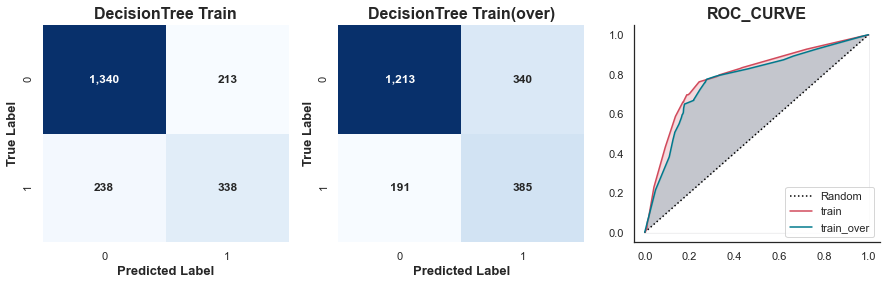

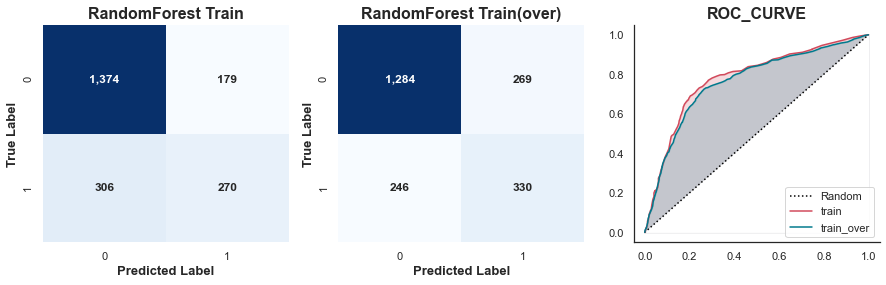

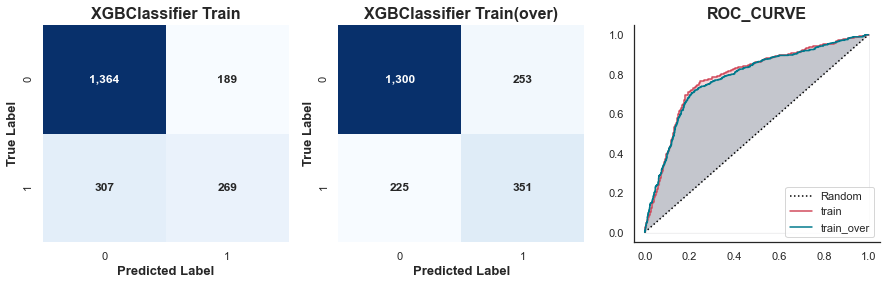

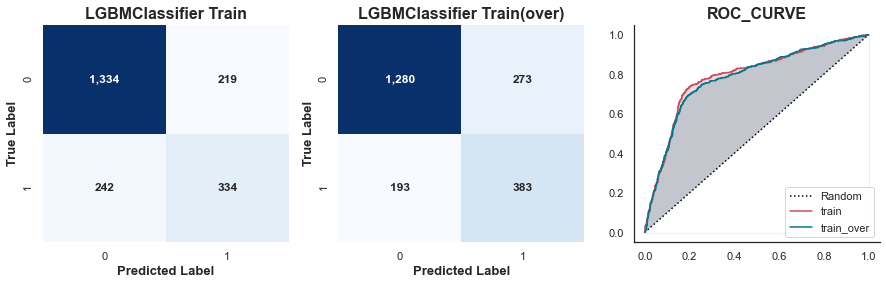

In [148]:
show_heatmap_roc(model_names, preds, tst)

In [ ]:
# SMOTE Oversampling은 모델의 성능을 오히려 떨어트렸습니다.